# <font color='blue'>Objective</font>

The project explores mortgage applications submitted in 2013
The data are from the Home Mortgage Disclosure Act (HMDA) website (https://www.ffiec.gov/hmda/hmdaproducts.htm).


In [ ]:
import pandas as pd
import numpy as np
#import h5py
from math import sin,cos,atan2,sqrt,radians
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

# <font color='blue'>Import dataset from the csv file</font>

The CSV file is large (2.8 GB). I will read it in chuncs, filter the features of interest and append to the dataframe.

The file's format is available here: https://www.ffiec.gov/hmdarawdata/FORMATS/2013HMDALARRecordFormat.pdf
and the code sheet is here:          https://www.ffiec.gov/hmdarawdata/FORMATS/2013HMDACodeSheet.pdf




In [ ]:
names = ['year','ID','agency','loan_type','property_type','loan_purpose','occupancy','loan_amount','preapproval','action','msa',
         'state','county','census','ethnicity','coethnicity','race1','race2','race3','race4','race5','corace1','corace2','corace3',
         'corace4','corace5','sex','cosex','income','purchaser','denial1','denial2','denial3','spread','hoepa','lien','edit',
         'sequence','population','min_pop','median_family_income','tract2msa_income','owner_occupied_num','sf_units_num',
         'date_ind']

dtype ={'year':int,'ID':str,'agency':str,'loan_type':int,'property_type':int,'loan_purpose':int,'occupancy':int,'loan_amount':int
        ,'preapproval':str,'action':int,'msa':str,'state':str,'county':str,'census':str,'ethnicity':str,'coethnicity':str,
        'race1':str,'race2':str,'race3':str,'race4':str,'race5':str,'corace1':str,'corace2':str,'corace3':str,'corace4':str,'corace5':str,
       'sex':int,'cosex':int,'income':str,'purchaser':str,'denial1':str,'denial2':str,'denial3':str,'spread':str,'hoepa':str,'lien':str,'edit':str,'sequence':str,
       'population':str,'min_pop':str,'median_family_income':str,'tract2msa_income':str,'owner_occupied_num':str,'sf_units_num':str,'date_ind':int}

usecols = ['year','ID','agency','loan_type','property_type','loan_purpose','loan_amount','action',
         'state','county','census','ethnicity','race1','sex','income','purchaser','spread',
         'sequence','population','median_family_income','tract2msa_income','sf_units_num']


I read the data in 1MB chuncks and keep mortgage applications that were:
1. Either originated or rejected by the lender
2. Made on single family homes
3. The purpose of the loan was home purchase (removed refinancing and home improvement)

In [8]:
data = pd.read_csv("2013HMDALAR - National/2013HMDALAR - National.csv",index_col=False,dtype=dtype,names=names,usecols = usecols ,iterator = True,chunksize=1000000)
hmda = pd.DataFrame(data = [])
for chunk in data: 
    hmda = pd.concat([hmda,chunk[((chunk['action']==1) | (chunk['action']==3)) & (chunk['property_type']==1)  & (chunk['loan_purpose']==1)]])
    print(hmda.shape)


(185270, 22)
(371042, 22)
(551973, 22)
(776140, 22)
(983002, 22)
(1199440, 22)
(1415668, 22)
(1640112, 22)
(1844782, 22)
(2064174, 22)
(2336886, 22)
(2560228, 22)
(2785072, 22)
(2972602, 22)
(3210100, 22)
(3408626, 22)
(3576380, 22)
(3578311, 22)


In [9]:
print(hmda.columns)
print(hmda.shape)

Index(['year', 'ID', 'agency', 'loan_type', 'property_type', 'loan_purpose',
       'loan_amount', 'action', 'state', 'county', 'census', 'ethnicity',
       'race1', 'sex', 'income', 'purchaser', 'spread', 'sequence',
       'population', 'median_family_income', 'tract2msa_income',
       'sf_units_num'],
      dtype='object')


In [10]:
# Save HMDA data into file
hmda.to_pickle('hmda13.pkl')
#store = pd.HDFStore('store_2.h5')
#store['hmda13'] = hmda
#store.close()

# <font color='blue'>Cleaning the Data</font>

In [2]:
# load data
hmda = pd.read_pickle('hmda13.pkl')

In [3]:
print(hmda.describe())

            year     loan_type  property_type  loan_purpose   loan_amount  \
count  3578311.0  3.578311e+06      3578311.0     3578311.0  3.578311e+06   
mean      2013.0  1.505685e+00            1.0           1.0  2.246644e+02   
std          0.0  8.203326e-01            0.0           0.0  2.393965e+02   
min       2013.0  1.000000e+00            1.0           1.0  1.000000e+00   
25%       2013.0  1.000000e+00            1.0           1.0  1.140000e+02   
50%       2013.0  1.000000e+00            1.0           1.0  1.760000e+02   
75%       2013.0  2.000000e+00            1.0           1.0  2.750000e+02   
max       2013.0  4.000000e+00            1.0           1.0  9.999900e+04   

             action           sex  
count  3.578311e+06  3.578311e+06  
mean   1.302133e+00  1.400076e+00  
std    7.162275e-01  6.355440e-01  
min    1.000000e+00  1.000000e+00  
25%    1.000000e+00  1.000000e+00  
50%    1.000000e+00  1.000000e+00  
75%    1.000000e+00  2.000000e+00  
max    3.000000e+0

## Remove missing observations

In [4]:
# convert income from str to int
print(hmda.shape)
hmda = hmda.drop(hmda[hmda['income'].str.find('NA') >=0].index)
hmda.loc[:,'income'] = hmda['income'].astype(int)
hmda.loc[hmda['tract2msa_income'].str.find('NA') >=0,'tract2msa_income'] = np.nan
hmda.loc[:,'tract2msa_income'] = hmda['tract2msa_income'].astype(np.float32)
hmda.loc[hmda['median_family_income'].str.find('NA') >=0,'median_family_income'] = np.nan
hmda.loc[:,'median_family_income'] = hmda['median_family_income'].astype(np.float32)
hmda.loc[pd.isnull(hmda['race1'])==True,'race1'] = '0'
hmda.loc[:,'race1'] = hmda['race1'].astype(int)
hmda = hmda[np.isnan(hmda['loan_amount']) == False]
print(hmda.shape)

(3578311, 22)
(3490541, 22)


## Identify and remove outliers

I use the z-score to identify outliers for 'loan_amount' and 'income'.  I keep observations that lie between [p25 - 1.5*IQR, p75 + 1.5*IQR]

In [5]:
#Compute the Z-score
scaler = StandardScaler()
scaler = scaler.fit(hmda.loan_amount.values.reshape(-1,1))
hmda['loan_amount_norm'] = scaler.transform(hmda.loan_amount.values.reshape(-1,1))
scaler = scaler.fit(hmda.income.values.reshape(-1,1))
hmda['income_norm'] = scaler.transform(hmda.income.values.reshape(-1,1))

c:\users\aya\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [6]:
def find_outlier(x,p25=0,p75=0,p1=0,p99=0,method='pct'):    
    if (method == 'iqr'):        
        iqr = p75 - p25
        #print(p75,p25,iqr)
        assert (iqr > 0), "p75 must be larger than p25"            
        return (x > p75 + 1.5*iqr) or (x < p25 - 1.5*iqr)
    else:        
        assert (p1<p99), "p1 must be smaller than p99"
        return (x>p99) or (x<p1)

In [7]:
print(hmda[['loan_amount_norm','income_norm']].describe(percentiles = [0.01,0.25,0.50,0.75,0.99]))
pcnt = np.percentile(hmda.loan_amount_norm,[25,75])
hmda['loan_amount_outlier'] = hmda['loan_amount_norm'].map(lambda x: find_outlier(x,p25=pcnt[0],p75=pcnt[1],method = 'iqr'))
pcnt = np.percentile(hmda.income_norm,[25,75])
hmda['income_outlier'] = hmda['income_norm'].map(lambda x: find_outlier(x,p25=pcnt[0],p75=pcnt[1],method = 'iqr'))
hmda = hmda[(hmda['loan_amount_outlier'] == False) & (hmda['income_outlier'] == False)]
print(hmda[['loan_amount_norm','income_norm']].describe(percentiles = [0.01,0.25,0.50,0.75,0.99]))


       loan_amount_norm   income_norm
count      3.490541e+06  3.490541e+06
mean      -9.389924e-17 -3.527328e-17
std        1.000000e+00  1.000000e+00
min       -1.017277e+00 -6.682664e-01
1%        -9.305130e-01 -5.618122e-01
25%       -4.966912e-01 -3.676897e-01
50%       -2.181319e-01 -1.986152e-01
75%        2.339561e-01  8.317547e-02
99%        3.435104e+00  2.969965e+00
max        4.556281e+02  6.193937e+01
       loan_amount_norm   income_norm
count      3.165719e+06  3.165719e+06
mean      -1.650443e-01 -1.685815e-01
std        4.743043e-01  2.812944e-01
min       -1.017277e+00 -6.682664e-01
1%        -9.350795e-01 -5.618122e-01
25%       -5.195239e-01 -3.802137e-01
50%       -2.637974e-01 -2.361873e-01
75%        1.152259e-01 -1.701678e-02
99%        1.133565e+00  6.592809e-01
max        1.329927e+00  7.594732e-01


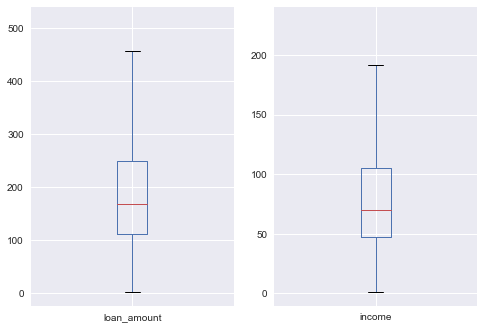

In [8]:
#plot the distributions
hmda.dropna().plot(y = ['loan_amount','income'],kind = 'box',subplots = True)
plt.show()

In [9]:
# Define new variables
hmda['lti'] = hmda.loan_amount/hmda.income                       # loan-to-income ratio
hmda['rel_inc'] = hmda.income*1000/hmda.median_family_income     # income of borrower relative to the median income in the MSA
hmda['log_loan_amount'] = np.log(hmda['loan_amount'])            # log of the loan amount  
hmda['log_income'] = np.log(hmda['income'])                      # log of income 

scaler = scaler.fit(hmda.lti.values.reshape(-1,1))
hmda['lti_norm'] = scaler.transform(hmda.lti.values.reshape(-1,1))

# <font color='blue'>Merge with HMDA lender file</font>

The HMDA lender file has information on the type of lender.

In [10]:
d = {'data':[]}
with open(r'2013HMDALAR - National/2013HMDAReporterPanel/2013HMDAReporterPanel.DAT') as f:    
    for line in f:
        d['data'].append(line)

In [11]:
reporter = pd.DataFrame(d)
reporter['ID'] = reporter.data.str[4:14]
reporter['agency'] = reporter.data.str[14:15]
reporter['name'] = reporter.data.str[95:125]
reporter['lender_type'] = reporter.data.str[94:95]
del reporter['data']
print(reporter.columns)

Index(['ID', 'agency', 'name', 'lender_type'], dtype='object')


In [12]:
hmda = hmda.merge(reporter,on=['ID','agency'],how = 'inner')

print(hmda.shape)

(3165719, 32)


In [14]:

# catagorize race, action, type of loan and type of lender
hmda.loc[hmda['race1']>5,'race1'] = 0
hmda['race_cat'] = pd.Categorical.from_codes(hmda['race1'], categories=['NA','American Indian or Alaska Native','Asian','African American','Native Hawaiian or Other Pacific Islander','White'])

hmda.loc[hmda['action'] ==3,'action'] = 0
hmda['action_cat'] = pd.Categorical.from_codes(hmda['action'], categories=['reject','accept'])

hmda.loc[:,'loan_type'] = hmda['loan_type'] - 1
hmda['loan_type_cat'] = pd.Categorical.from_codes(hmda['loan_type'], categories=['conventional','FHA','VA','FSA'])

hmda['lender_type'] = hmda['lender_type'].astype(int)
hmda.loc[hmda['lender_type']==5,'lender_type'] = 4
hmda['lender_type_cat'] = pd.Categorical.from_codes(hmda['lender_type'], categories=['Depository','Depository MBS','BHC MBS','HUD','Affiliate'])
print(hmda.groupby('lender_type_cat').count())

                    year       ID   agency  loan_type  property_type  \
lender_type_cat                                                        
Depository       1576608  1576608  1576608    1576608        1576608   
Depository MBS    232046   232046   232046     232046         232046   
BHC MBS             9274     9274     9274       9274           9274   
HUD              1337049  1337049  1337049    1337049        1337049   
Affiliate          10742    10742    10742      10742          10742   

                 loan_purpose  loan_amount   action    state   county  \
lender_type_cat                                                         
Depository            1576608      1576608  1576608  1554604  1576608   
Depository MBS         232046       232046   232046   231583   232046   
BHC MBS                  9274         9274     9274     9274     9274   
HUD                   1337049      1337049  1337049  1334948  1337049   
Affiliate               10742        10742    10742    10

In [15]:
hmda.to_pickle('hmda13.pkl')

# <font color='blue'> Exploring the Dataset</font>

In [3]:
hmda = pd.read_pickle('hmda13.pkl')
print(hmda.describe())
print(hmda.shape)
print(hmda.columns)

            year     loan_type  property_type  loan_purpose   loan_amount  \
count  3165719.0  3.165719e+06      3165719.0     3165719.0  3.165719e+06   
mean      2013.0  5.554906e-01            1.0           1.0  1.876253e+02   
std          0.0  8.455494e-01            0.0           0.0  1.038650e+02   
min       2013.0  0.000000e+00            1.0           1.0  1.000000e+00   
25%       2013.0  0.000000e+00            1.0           1.0  1.100000e+02   
50%       2013.0  0.000000e+00            1.0           1.0  1.660000e+02   
75%       2013.0  1.000000e+00            1.0           1.0  2.490000e+02   
max       2013.0  3.000000e+00            1.0           1.0  5.150000e+02   

             action         race1           sex        income  \
count  3.165719e+06  3.165719e+06  3.165719e+06  3.165719e+06   
mean   8.464930e-01  4.293501e+00  1.374306e+00  8.079618e+01   
std    3.604756e-01  1.514861e+00  5.687476e-01  4.492074e+01   
min    0.000000e+00  0.000000e+00  1.000000e+0

## Plot Distributions

I begin by looking at the distribution of loan amount, borrower income and loan-to-income ratio. Both are log normally distributed. loan amount has an increase in frequency around 420K which is close to the conforming loan limit (the max loan amount that can be sold to Fannie Mae and Freddie Mac).



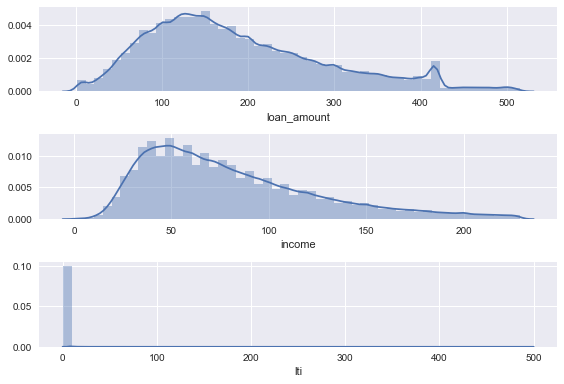

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
sns.distplot(hmda.loan_amount,ax=ax1)

ax2 = fig.add_subplot(312)
sns.distplot(hmda.income,ax=ax2)

plt.tight_layout()

plt.show()

## The Lenders

There are 5 types of lenders: depository institutions, subsidiaries of depositories, subsidiaries of bank holding companies (BHCs), independent mortgage companies (HUD) and affiliated mortgage companies. We see that the majority of applications were received by depository institutions and mortgge companies. We can also see that depositories rejected a higher fraction of their applications.

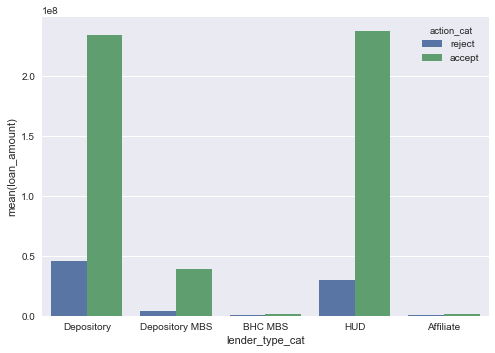

In [46]:
hmda_view = hmda.groupby(['lender_type_cat','action_cat'])['loan_amount'].sum().reset_index()
sns.barplot(x = 'lender_type_cat',y = 'loan_amount',data=hmda_view,hue='action_cat')
plt.show()

Looking at the top 50 lenders, Wells Fargo receives the majority of applications, followed by JP Morgan. We can see that most of the lending is done through depository institutions

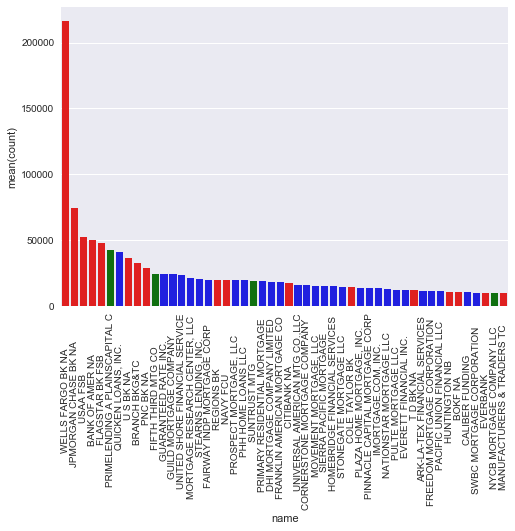

In [76]:
lenders = hmda.groupby(['name','lender_type_cat'])['loan_amount'].agg({'count':np.size}).reset_index()
lenders = lenders.sort_values('count',ascending=False).reset_index()
#print(lenders.loc[:,'lender_type_cat'].unique())

def set_color(x):    
    if (x == 'Depository'):
        return 'red'
    elif (x == 'Depository MBS'):
        return 'green'
    elif (x == 'HUD'):
        return 'blue'
    elif (x == "BHC MBS"):
        return 'yellow'
    else:
        return 'purple'
#print(lenders)
clrs = list(map(set_color,lenders.loc[0:50,'lender_type_cat']))
f1=sns.barplot(x = 'name',y = 'count',data=lenders[0:50],palette=clrs)
plt.setp(f1.get_xticklabels(), rotation=90)
plt.show()

## Loan characteristics

Next, I will identify which loans were more likely to be rejected. Comparing the distribution of loans that were accepted to those that were rejected:
1. While there are many loans with low loan-to-income that were rejected, those with high loan-to-income ratio were more likely to be rejected.
2. Larger loans were more likely to be accepted. This is likely due to the positive correlation between loan amount and borrower income
3. Applications made in richer census tracts (compared to the average income in the MSA) were more likely to be accepted

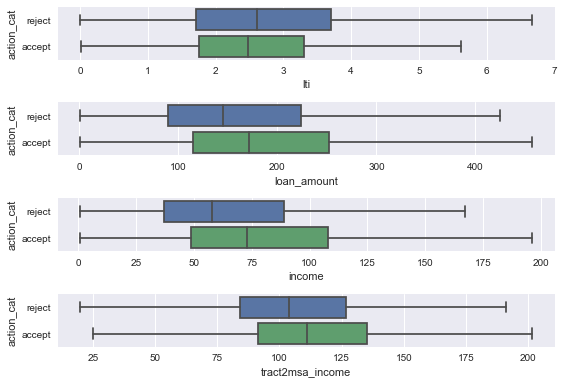

In [102]:
fig = plt.figure()
ax1 = fig.add_subplot(411)
sns.boxplot(x="lti", y="action_cat", data=hmda,showfliers = False,ax=ax1);

ax2 = fig.add_subplot(412)
sns.boxplot(x="loan_amount", y="action_cat", data=hmda,showfliers = False,ax=ax2);

ax3 = fig.add_subplot(413)
sns.boxplot(x="income", y="action_cat", data=hmda,showfliers = False,ax=ax3);

ax4 = fig.add_subplot(414)
sns.boxplot(x="tract2msa_income", y="action_cat", data=hmda,showfliers = False,ax=ax4);

plt.tight_layout()
plt.show()


The figure below examines correlation between the loan-to-income ratio, log income, log loan amount, relative income and tract to MSA income.
We can see that loans with high loan-to-income ratio are more likely to be rejected. The plots also show that those in low income tract take loans with higher loan-to-income ratio. The same holds true for those with low relative income

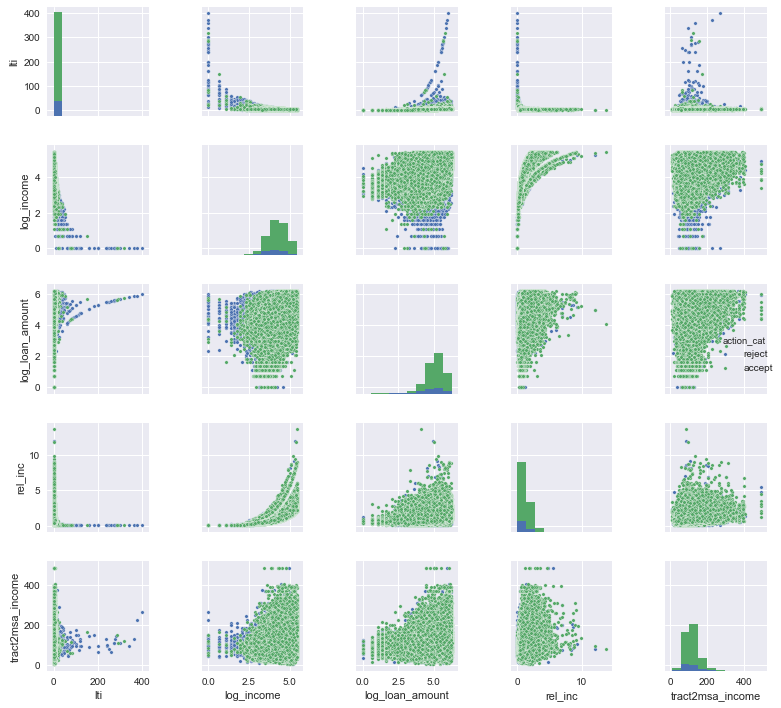

In [43]:
#Find correlations between the variables
sns.pairplot(data=hmda.dropna().sample(frac=0.1),size = 2, vars=['lti','log_income','log_loan_amount','rel_inc','tract2msa_income'],hue='action_cat',markers = '.')
plt.tight_layout()
plt.show()

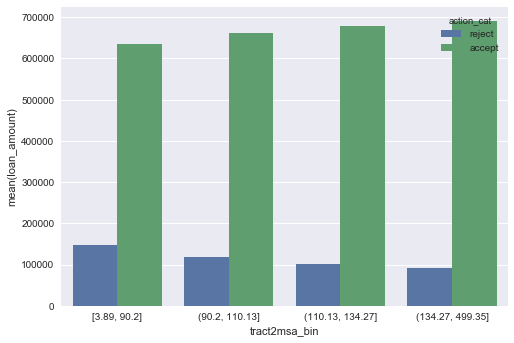

In [23]:
hmda['tract2msa_bin'] = pd.qcut(hmda['tract2msa_income'],q = [0,0.25,0.5,0.75,1])
hmda_view = hmda.groupby(['tract2msa_bin','action_cat'])['loan_amount'].count().reset_index()
sns.barplot(x = 'tract2msa_bin',y = 'loan_amount',data=hmda_view,hue='action_cat')
plt.show()

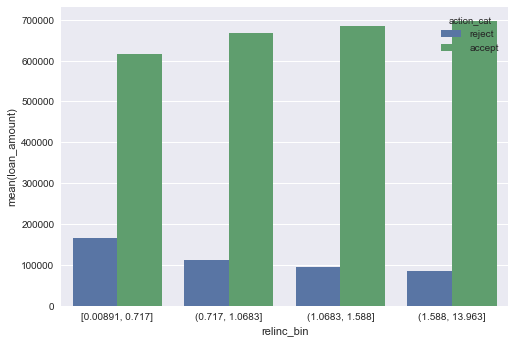

In [22]:
hmda['relinc_bin'] = pd.qcut(hmda['rel_inc'],q = [0,0.25,0.5,0.75,1])
hmda_view = hmda.groupby(['relinc_bin','action_cat'])['loan_amount'].count().reset_index()
sns.barplot(x = 'relinc_bin',y = 'loan_amount',data=hmda_view,hue='action_cat')
plt.show()

## Analyzing by state
The three states with the most applications were Texas, California and Florida. Puerto Rico had the highest rejection rate (>30%), followed by Florida (>20%)

In [89]:
state_dict = {'01':'AL','02':'AK','04':'AZ', '05':'AR','06':'CA','08':'CO','09':'CT','10':'DE','11':'DC',
              '12':'FL','13':'GA','66':'GU','15':'HI','16':'ID','17':'IL','18':'IN','19':'IA','20':'KS','21':'KY','22':'LA',
              '23':'ME','24':'MD','25':'MA','26':'MI','27':'MN','28':'MS','29':'MO','30':'MT','31':'NE','32':'NV','33':'NH',
              '34':'NJ','35':'NM','36':'NY','37':'NC','38':'ND','39':'OH','40':'OK','41':'OR','42':'PA','72':'PR','44':'RI',
              '45':'SC','46':'SD','47':'TN','48':'TX','49':'UT','50':'VT','51':'VA','78':'VI','53':'WA','54':'WV','55':'WI','56':'WY'}
              


In [92]:
hmda = hmda[pd.isnull(hmda['state'])==False]
hmda.loc[:,'state_abbrv'] = list(map(lambda x:state_dict[x],hmda['state']))

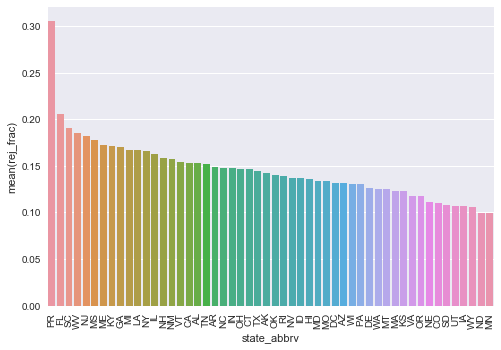

In [97]:
hmda['action_cat'] = hmda['action_cat'].astype(str)
hmda_view = hmda.groupby(['state_abbrv','action_cat'])['loan_amount'].count().reset_index()
hmda_view_tot = hmda.groupby(['state_abbrv'])['loan_amount'].count().reset_index()
hmda_view_tot.columns = ['state_abbrv','total']
hmda_view = hmda_view.merge(hmda_view_tot,on='state_abbrv',how='inner')
hmda_view = hmda_view[hmda_view['action_cat']=='reject']
hmda_view['rej_frac'] = hmda_view['loan_amount']/hmda_view['total']
hmda_view = hmda_view.sort_values('rej_frac',ascending=False)
fig, ax = plt.subplots()
f1 = sns.barplot(x = 'state_abbrv',y = 'rej_frac',data=hmda_view,ax=ax)
plt.setp(f1.get_xticklabels(), rotation=90)
plt.show()

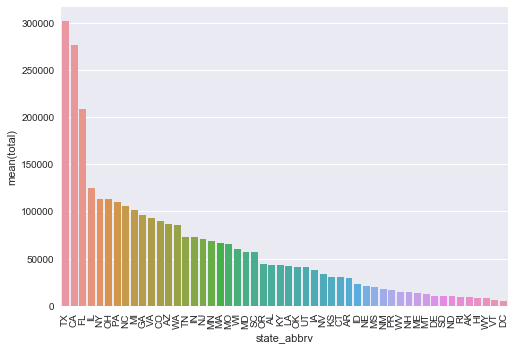

In [98]:
hmda_view_tot = hmda_view_tot.sort_values('total',ascending=False)
fig, ax = plt.subplots()
f1 = sns.barplot(x = 'state_abbrv',y = 'total',data=hmda_view_tot,ax=ax)
plt.setp(f1.get_xticklabels(), rotation=90)

plt.show()

In [105]:
hmda.loc[hmda['population'].str.find('NA') >=0,'population'] = np.nan
hmda['population'] = hmda['population'].astype(np.float32)
hmda.loc[hmda['sf_units_num'].str.find('NA') >=0,'sf_units_num'] = np.nan
hmda['sf_units_num'] = hmda['sf_units_num'].astype(np.float32)
print(hmda.columns)

Index(['year', 'ID', 'agency', 'loan_type', 'property_type', 'loan_purpose',
       'loan_amount', 'action', 'state', 'county', 'census', 'ethnicity',
       'race1', 'sex', 'income', 'purchaser', 'spread', 'sequence',
       'population', 'median_family_income', 'tract2msa_income',
       'sf_units_num', 'loan_amount_norm', 'income_norm',
       'loan_amount_outlier', 'income_outlier', 'lti', 'rel_inc',
       'log_loan_amount', 'log_income', 'name', 'lender_type', 'race_cat',
       'action_cat', 'loan_type_cat', 'lender_type_cat', 'state_abbrv'],
      dtype='object')


# <font color='blue'> Predicting application rejection</font>

Following the steps described in http://machinelearningmastery.com/machine-learning-in-python-step-by-step/

In [ ]:
hmda = pd.concat([hmda,pd.get_dummies(hmda['lender_type_cat'])],axis = 1)
hmda = pd.concat([hmda,pd.get_dummies(hmda['race_cat'])],axis = 1)
hmda = pd.concat([hmda,pd.get_dummies(hmda['action_cat'])],axis = 1)
hmda = pd.concat([hmda,pd.get_dummies(hmda['loan_type_cat'])],axis = 1)
hmda = pd.concat([hmda,pd.get_dummies(hmda['state_abbrv'])],axis = 1)
hmda = hmda.dropna()

#X = hmda.loc[:,['log_loan_amount','log_income','lti','Depository',  'HUD',  'African American', 'Asian', 'White','rel_inc','tract2msa_income','AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
#       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI',
#       'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY',
#       'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
#       'VT', 'WA', 'WI', 'WV', 'WY']].values


X = hmda.loc[:,['lti','Depository',  'HUD',  'African American', 'Asian', 'White','rel_inc','tract2msa_income','population', 'sf_units_num','PR','CA','TX']].values

Y = hmda.loc[:,'accept'].values
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [56]:
#scoring = 'accuracy'
scoring = 'roc_auc'

In [57]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [58]:
models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))
#models.append(('RFC', RandomForestClassifier(n_estimators=1000)))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.635573 (0.004011)


In [59]:
# Make predictions on validation dataset
knn = LogisticRegression(C=0.2)
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.854096700336
[[   555  91091]
 [    99 533258]]
             precision    recall  f1-score   support

          0       0.85      0.01      0.01     91646
          1       0.85      1.00      0.92    533357

avg / total       0.85      0.85      0.79    625003

